In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from model.rnn import GRUDecoder
from model.autoencoder import AutoEncoder
from data_processing.pipeline import encoding_pipeline

In [2]:
def get_device():
    # Check if CUDA is available
    if torch.cuda.is_available():
        # If CUDA is available, select the first CUDA device
        device = torch.device("cuda:0")
        print("Using CUDA device:", torch.cuda.get_device_name(0))
    # Check for MPS availability on supported macOS devices (requires PyTorch 1.12 or newer)
    elif torch.backends.mps.is_available():
        # If MPS is available, use MPS device
        device = torch.device("mps")
        print("Using MPS (Metal Performance Shaders) device")
    else:
        # Fallback to CPU if neither CUDA nor MPS is available
        device = torch.device("cpu")
        print("Using CPU")
    return device
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
# read in data and prepare transformations
data = pd.read_csv('data/other_data/PreFer_fake_data.csv')
targets = pd.read_csv('data/other_data/PreFer_fake_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

In [4]:
sequences = encoding_pipeline(data, codebook)

# Train the autoencoder

In [5]:
from model.dataset import PretrainingDataset

pretrain_dataset = PretrainingDataset(sequences)

In [6]:
### Initialization of the Autoencoder 
HIDDEN_DIM = 256
ENCODING_SIZE = 128
BATCH_SIZE = 16
num_epochs_autoencoder = 100
learning_rate_autoencoder = 1e-3

SEQ_LEN = pretrain_dataset.get_seq_len()
vocab_size = pretrain_dataset.get_vocab_size()

train_dataloader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder = AutoEncoder(vocab_size=vocab_size, embedding_size=HIDDEN_DIM, encoding_size=ENCODING_SIZE, sequence_len=SEQ_LEN).to(device)

loss_f1 = nn.HuberLoss(delta=1.0)
loss_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
loss_cos = nn.CosineEmbeddingLoss()
optimizer = optim.RAdam( autoencoder.parameters(), lr = learning_rate_autoencoder, weight_decay=1e-3, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs_autoencoder, eta_min = 1e-6, last_epoch = -1)

/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
autoencoder.train()
# device = torch.device("cpu") # mps is not working for Me (Mikkel)
autoencoder.to(device)
loss_metric = []
for epoch in range(num_epochs_autoencoder):
    loss_epoch_metric = []
    for year, seq in train_dataloader:
        optimizer.zero_grad()
        year = year.to(device)
        seq = seq.to(device)

        x1, x2 = autoencoder(year, seq)
        loss = loss_cls(x2.permute(0,2,1), seq.long()) + loss_cos(x1.reshape(x1.size(1) * x1.size(0), -1 ), 
                                                                autoencoder.embedding(year, seq).view(x1.size(1) * x1.size(0), -1), 
                                                                torch.ones(seq.size(0) * seq.size(1)).to(device))
         #+ 0.7 * loss_f1(x1, autoencoder.embedding(year, seq)) +  
        loss_epoch_metric.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    ## After epoch end
    scheduler.step()
    loss_metric.append(np.mean(loss_epoch_metric))
    print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')

epoch 0 	 Loss: 11.83 and LR: 0.00099975
epoch 1 	 Loss: 5.751 and LR: 0.00099901
epoch 2 	 Loss: 4.458 and LR: 0.00099778
epoch 3 	 Loss: 3.982 and LR: 0.00099606
epoch 4 	 Loss: 3.726 and LR: 0.00099385
epoch 5 	 Loss: 3.563 and LR: 0.00099115
epoch 6 	 Loss: 3.461 and LR: 0.00098797
epoch 7 	 Loss: 3.382 and LR: 0.00098431
epoch 8 	 Loss: 3.322 and LR: 0.00098017
epoch 9 	 Loss: 3.27 and LR: 0.00097555
epoch 10 	 Loss: 3.227 and LR: 0.00097047
epoch 11 	 Loss: 3.191 and LR: 0.00096492
epoch 12 	 Loss: 3.148 and LR: 0.00095892
epoch 13 	 Loss: 3.102 and LR: 0.00095246
epoch 14 	 Loss: 3.064 and LR: 0.00094556
epoch 15 	 Loss: 3.026 and LR: 0.00093822
epoch 16 	 Loss: 2.991 and LR: 0.00093044
epoch 17 	 Loss: 2.961 and LR: 0.00092224
epoch 18 	 Loss: 2.935 and LR: 0.00091363
epoch 19 	 Loss: 2.915 and LR: 0.0009046
epoch 20 	 Loss: 2.888 and LR: 0.00089518
epoch 21 	 Loss: 2.865 and LR: 0.00088537
epoch 22 	 Loss: 2.855 and LR: 0.00087518
epoch 23 	 Loss: 2.809 and LR: 0.00086462
epoc

KeyboardInterrupt: 

In [7]:
torch.save(autoencoder.state_dict(), 'weights/autoencoder_10_05.pt')

In [8]:
import umap
import matplotlib.pyplot as plt

In [10]:
w = autoencoder.embedding.answer_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
wp.shape

(2068, 2)

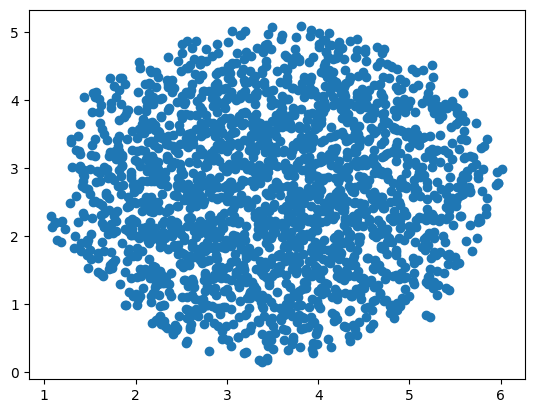

In [12]:
plt.scatter(wp[:,0], wp[:,1])

# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [7]:
# its not everyone we have a target for, so we do restrict the data to 
# the ones with known outcomes

train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

In [8]:
# structure the data as a Dict[person_id, survey_embedding_sequence] 
# where survey_embedding_sequence is a tensor of size 14 x embedding_dimension
#rnn_data = {person_id:
#                    autoencoder(
#                        torch.tensor(
#                            [year-2007 for year, _ in wave_responses.items()]
#                        ).to(device),
##                        torch.tensor(
 #                           [ wave_response for _, wave_response in wave_responses.items()]
##                        ).to(device),
# #                       encode_only=True,
#                    )
#                for person_id, wave_responses in sequences.items()
#            }

In [13]:
rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

In [14]:
# split data based on the splits made for the target
train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}


In [16]:
from model.dataset import FinetuningDataset
train_dataset = FinetuningDataset(train_data, targets = targets)
test_dataset = FinetuningDataset(test_data, targets = targets)

rnn_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)

In [83]:
# ft - fine-tuning

HIDDEN_SIZE = 24

num_epochs_ft = 40
learning_rate_ft = 5e-4

rnn_model = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_seq_len=14
).to(device)

# Define loss function and optimizer for RNN
ft_loss = torch.nn.BCELoss()
ft_optimizer = torch.optim.RAdam(list(rnn_model.parameters()) +list(autoencoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-3, decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

# Training loop
rnn_model.train()
autoencoder.train()
print("Ready!")

The model is going to set all input MASK to None
Ready!


In [84]:
loss_per_epoch = []
for epoch in range(num_epochs_ft):
    print(epoch)
    loss_per_step = []
    for batch in train_dataloader:
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        survey_embeddings = autoencoder(input_year, input_seq, encode_only = True).view(bs,ss, -1)



        # Forward pass
        xx = rnn_model(survey_embeddings)
        outputs = torch.nn.functional.sigmoid(xx)

        loss = ft_loss(torch.flatten(outputs), labels)  
        loss_per_step.append(loss.detach().cpu().numpy())

        #loss.backward(retain_graph=True)
        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {loss_per_epoch[-1]:.4f}")
    

0
Epoch 1/40, Loss: 0.7528
1
Epoch 2/40, Loss: 1.7066
2
Epoch 3/40, Loss: 1.3687
3
Epoch 4/40, Loss: 1.3773
4
Epoch 5/40, Loss: 1.4083
5


KeyboardInterrupt: 

In [29]:
import torch
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(torch.float).to(device)
            
            # Forward pass
            outputs = model(inputs)
            outputs = torch.nn.functional.sigmoid(outputs)
            
            # Convert outputs to binary predictions
            predicted_labels = (outputs > 0.5).float()  # Threshold predictions
            print(labels)
            print(predicted_labels.flatten())
            print('')
            
            # Store predictions and actual labels
            predictions.append(predicted_labels.flatten())
            actuals.append(labels.flatten())
    
    # Concatenate all the batches
    predictions = torch.cat(predictions)
    actuals = torch.cat(actuals)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    
    return precision, recall, f1


In [30]:
precision, recall, f1 = evaluate_model(rnn_model, test_dataloader)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

tensor([0., 0., 0., 1., 0., 1.], device='mps:0')
tensor([0., 0., 0., 0., 0., 0.], device='mps:0')

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
